# NIH Chest X-ray Dataset

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

## National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

### Data limitations:
- 1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
 - 2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
 - .Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/nih-chest-xrays/data/home <br>
Research paper : http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf <br>
Research paper : https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ <br>
Research paper : https://arxiv.org/pdf/1711.05225.pdf <br>
Blog : https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

- 1. No strict latency constraints.

<h2> 2.1 Data </h2>

### File contents
Image format: 112,120 total images with size 1024 x 1024

**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h

**Data_entry_2017.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y

**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia



### Goal

The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the flow_from_dataframe to deal with messier datasets


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<h1> Creating data for model </h1>

In [2]:
data = pd.read_csv('../input/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
56041,00013993_097.png,Effusion|Infiltration,97,13993,43,M,AP,2500,2048,0.168,0.168,NaN,../input/images_007/images/00013993_097.png
68082,00016801_007.png,No Finding,7,16801,47,F,PA,2760,2991,0.143,0.143,NaN,../input/images_008/images/00016801_007.png
51954,00013111_087.png,Infiltration,87,13111,22,M,PA,2992,2991,0.143,0.143,NaN,../input/images_006/images/00013111_087.png


In [3]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
84601,00020826_009.png,Consolidation,9,20826,22,M,AP,3056,2544,0.139,0.139,NaN,../input/images_009/images/00020826_009.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2211,00000583_001.png,,1,583,38,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000583_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20843,00005566_004.png,Atelectasis|Infiltration,4,5566,85,M,PA,2500,2048,0.171,0.171,NaN,../input/images_003/images/00005566_004.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


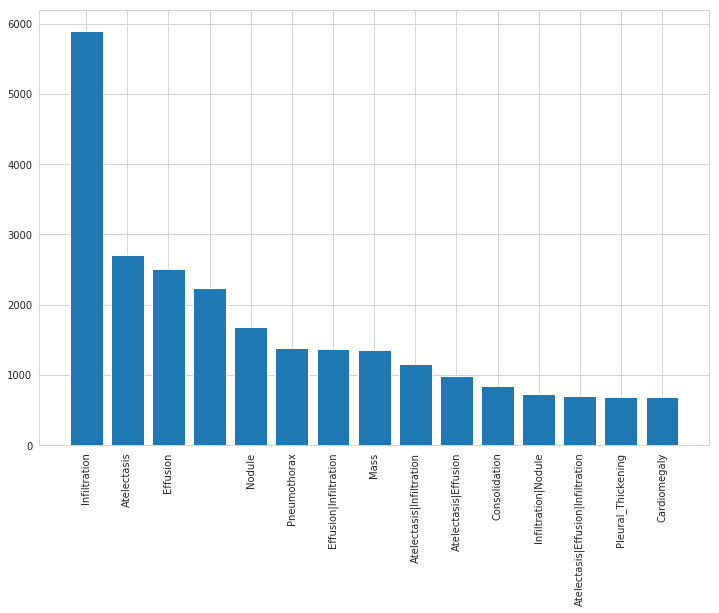

In [5]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [6]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 32000 test 8000


In [8]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 28800 valid 3200


In [9]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)






Using TensorFlow backend.


In [10]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen




In [11]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 28800 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3200 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3200 images


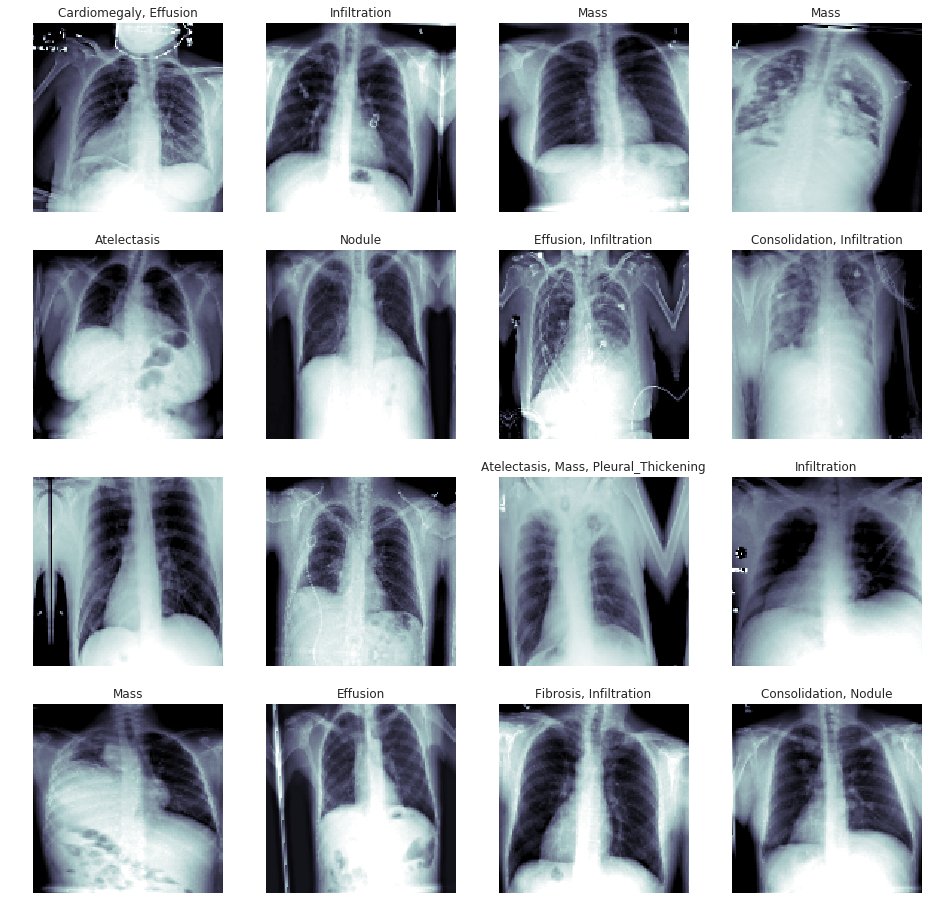

In [12]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

<h1> Create a simple MobileNet model </h1>

In [13]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [14]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 30)
                                  

Epoch 1/30
100/100 [==============================] - 96s 956ms/step - loss: 0.4654 - binary_accuracy: 0.8420 - mean_absolute_error: 0.1976 - val_loss: 0.8961 - val_binary_accuracy: 0.8580 - val_mean_absolute_error: 0.1468
Epoch 2/30
100/100 [==============================] - 80s 800ms/step - loss: 0.4160 - binary_accuracy: 0.8512 - mean_absolute_error: 0.1933 - val_loss: 1.0191 - val_binary_accuracy: 0.7783 - val_mean_absolute_error: 0.2180
Epoch 3/30
100/100 [==============================] - 79s 792ms/step - loss: 0.4005 - binary_accuracy: 0.8555 - mean_absolute_error: 0.1988 - val_loss: 0.6543 - val_binary_accuracy: 0.8770 - val_mean_absolute_error: 0.1376
Epoch 4/30
100/100 [==============================] - 79s 791ms/step - loss: 0.3695 - binary_accuracy: 0.8608 - mean_absolute_error: 0.1967 - val_loss: 0.3769 - val_binary_accuracy: 0.8714 - val_mean_absolute_error: 0.1566
Epoch 5/30
100/100 [==============================] - 80s 800ms/step - loss: 0.3582 - binary_accuracy: 0.867

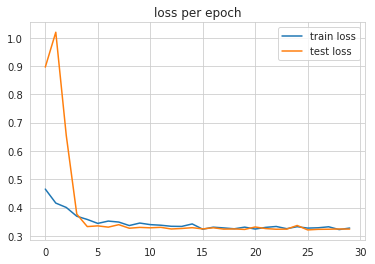

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.title('loss per epoch')
plt.show()

In [16]:
print('test binary accuracy = ',multi_disease_model.evaluate(test_X,test_Y, verbose=0)[1])

test binary accuracy =  0.8819862008094788


In [17]:
y_pred = multi_disease_model.predict(test_X)

In [18]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 22.27%, predicted: 21.06%
Cardiomegaly: actual: 4.39%, predicted: 6.02%
Consolidation: actual: 9.28%, predicted: 7.33%
Edema: actual: 4.00%, predicted: 4.68%
Effusion: actual: 26.66%, predicted: 20.71%
Emphysema: actual: 5.08%, predicted: 4.16%
Fibrosis: actual: 2.83%, predicted: 3.70%
Infiltration: actual: 36.82%, predicted: 40.02%
Mass: actual: 11.13%, predicted: 10.04%
Nodule: actual: 12.50%, predicted: 17.22%
Pleural_Thickening: actual: 6.93%, predicted: 5.77%
Pneumonia: actual: 3.03%, predicted: 3.28%
Pneumothorax: actual: 10.45%, predicted: 7.64%


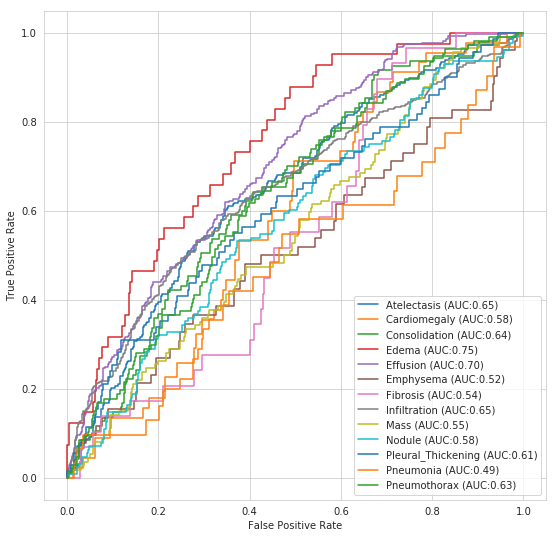

In [19]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


In [20]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(test_Y.astype(int), y_pred))

roc score =  0.6067806643240767


## Observation -
* we have 60.67 roc_auc_score